# Training Deep Learning

## Reference and Memo about this code 
- pytorch version 
- please run with Colab pro+ environment
- https://cs230.stanford.edu/blog/handsigns/
- https://teddylee777.github.io/pytorch/pytorch-cnn-rps

## Import

In [ ]:
# Here we import everything we need for the project
%matplotlib inline
from google.colab import files
import os

# Pytorch
import torch
torch.manual_seed(24) # for experiment 
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from tqdm import tqdm

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix         # Helps present results as a confusion-matrix

# Import of keras model and hidden layers for convolutional network
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path = '/content/drive/MyDrive/Dolphin/Dataset'

## Dataset Setting

- image_folder 
- train_loader

In [ ]:
image_folder = datasets.ImageFolder(root='/content/drive/MyDrive/Dolphin/Dataset',
                                    transform=transforms.Compose([
                                        transforms.Resize((64, 64)),              # resize the image to 64x64 
                                        transforms.RandomHorizontalFlip(0.5),     # randomly flip image horizontally with probabilty 50%
                                        transforms.ToTensor()]))
# check the label value 
print(image_folder.class_to_idx)
print(image_folder)

{'Dataset01': 0, 'Dataset02': 1, 'Dataset03': 2, 'Dataset04': 3, 'Dataset05': 4, 'Dataset06': 5, 'Dataset07': 6, 'Dataset08': 7}
Dataset ImageFolder
    Number of datapoints: 2406
    Root location: /content/drive/MyDrive/Dolphin/Dataset
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
train_indices, test_indices = train_test_split(list(range(len(image_folder.targets))), 
                                              test_size=0.2, 
                                              stratify=image_folder.targets)

train_dataset = torch.utils.data.Subset(image_folder, train_indices)
test_dataset = torch.utils.data.Subset(image_folder, test_indices)

print(len(train_dataset))
print(len(test_dataset))

1924
482


In [ ]:
# setting for data loader 
batch_size = 32 # batch size
num_workers = 8 # num of thread for parallel computing 

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,         # image dataset
                                           batch_size=batch_size, 
                                           shuffle=True,          # shuffle opetion
                                           num_workers=8)         # num of num_workers 

test_loader = torch.utils.data.DataLoader(test_dataset,           # originally, the root path of a seperate Validation Set must be specified
                                          batch_size=batch_size,  # set batch size
                                          shuffle=False,          # shuffle or not 
                                          num_workers=8)          # set num_workers                                            

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Extract one batch 
images, labels = next(iter(train_loader))

# There are 32 batches loaded in images and labels, respectively
# Images consist of 32 images of 64 X 64 RGB images in one batch
images.shape, labels.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

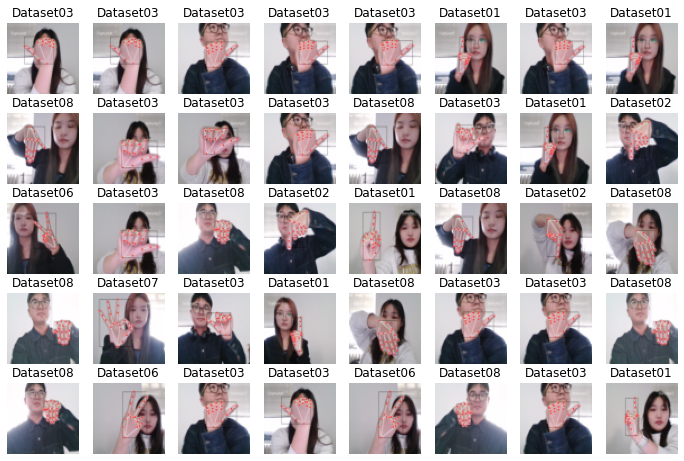

In [ ]:
# Attribute of ImageFolder class_to_idx assign 
labels_map = {v:k for k, v in image_folder.class_to_idx.items()}

figure = plt.figure(figsize=(12, 8))
cols, rows = 8, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    img, label = images[sample_idx], labels[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(torch.permute(img, (1, 2, 0)))
plt.show()

## Building Model: Simple CNN 

In [ ]:
# setting device (cuda:0 or cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        self.sequential = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Linear(2*2*128, 8)
    
    def forward(self, x):
        x = self.sequential(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x        


In [ ]:
model = CNNModel() # create Model
model.to(device)   # load on device (cpu or cuda)

CNNModel(
  (sequential): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=8, bias=True)
)

In [ ]:
# A summary of the CNN Model's structure and number of parameters are summarized with tochsummary.summary
from torchsummary import summary

summary(model, (3, 64, 64))

In [ ]:
# setting optimizer with model.parameters()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# setting loss function
# because Multi-Class Classification, we're setting CrossEntropy Loss Function
loss_fn = nn.CrossEntropyLoss()

## Training

In [ ]:
def model_train(model, data_loader, loss_fn, optimizer, device):
    # setting model's train mode with train()
    model.train()
    
    # temporary variables for loss and accuracy calculations, initialize with 0
    running_loss = 0
    corr = 0
    
    # Wrapping with tqdm to monitor the training status with progress bar
    prograss_bar = tqdm(data_loader)
    
    # start training with mini-batch
    for img, lbl in prograss_bar:
        # upload image, label data on device
        img, lbl = img.to(device), lbl.to(device)
        
        # initialize accumulated gradient
        optimizer.zero_grad()
        
        # proceed to Forware Propagation to obtain results 
        output = model(img)
        
        # calculate the loss by substituting the output, label value for the loss function
        loss = loss_fn(output, lbl)
        
        # perform Back Propagation to calculate the differential value.
        loss.backward()
        
        # update the calculated gradient 
        optimizer.step()
        
        # max(dim=1) of output returns max probability and max index
        # ignore the max probability, and store the max index in the pred to derive accuracy by comparing it with the label value
        _, pred = output.max(dim=1)
        
        # pred.eq(lbl).sum() calculates the sum of the correctly matched labels. item() extracts the value from the tensor
        # Sum accumulates in corr
        corr += pred.eq(lbl).sum().item()
        
        # The loss value is the average loss of one batch. 
        # img.size(0) is the batch size. 
        # multiplying loss and img.size(0) calculates the total loss of one batch
        # after accumulating it, the average loss is calculated by dividing it by the total number of datasets at the end of the epoch.
        running_loss += loss.item() * img.size(0)
        
    # Dividing the accumulated number of correct answers by the total number yields accuracy
    acc = corr / len(data_loader.dataset)
    
    # 평균 손실(loss)과 정확도를 반환합니다.
    # train_loss, train_acc
    return running_loss / len(data_loader.dataset), acc

## Evaluating

In [ ]:
def model_evaluate(model, data_loader, loss_fn, device):
    # set model as evaluation mode with model.eval() 
    # This is a necessary procedure for evaluation to change the role of the layer such as dropout
    model.eval()
    
    # It is essential to prevent Gradient from being updated
    with torch.no_grad():
        # temporary variables for loss and accuracy calculations, initialize with 0
        corr = 0
        running_loss = 0
        
        # process evaluation for each batch 
        for img, lbl in data_loader:
            # load data on device
            img, lbl = img.to(device), lbl.to(device)
            
            # proceed to Forware Propagation to obtain results 
            output = model(img)
            
            # max(dim=1) of output returns max probability and max index
            # ignore the max probability, and store the max index in the pred to derive accuracy by comparing it with the label value
            _, pred = output.max(dim=1)
            
            # pred.eq(lbl).sum() calculates the sum of the correctly matched labels. item() extracts the value from the tensor
            # Sum accumulates in corr
            corr += torch.sum(pred.eq(lbl)).item()
            
            # The loss value is the average loss of one batch. 
            # img.size(0) is the batch size. 
            # multiplying loss and img.size(0) calculates the total loss of one batch
            # after accumulating it, the average loss is calculated by dividing it by the total number of datasets at the end of the epoch.
            running_loss += loss_fn(output, lbl).item() * img.size(0)
        
        # calculate accuracy of validation
        # calculates the final accuracy by dividing the accumulated number of correct answers by the total number of datasets
        acc = corr / len(data_loader.dataset)
        
        # return results 
        # val_loss, val_acc
        return running_loss / len(data_loader.dataset), acc

In [ ]:
# set maximum of Epoch
num_epochs = 10

min_loss = np.inf

# Epoch 별 훈련 및 검증을 수행합니다.
for epoch in range(num_epochs):
    # Model Training
    train_loss, train_acc = model_train(model, train_loader, loss_fn, optimizer, device)

    val_loss, val_acc = model_evaluate(model, test_loader, loss_fn, device)   
    
    # If val_loss is improved, renew min_loss and store the weights of the model
    if val_loss < min_loss:
        print(f'[INFO] val_loss has been improved from {min_loss:.5f} to {val_loss:.5f}. Saving Model!')
        min_loss = val_loss
        torch.save(model.state_dict(), 'DNNModel.pth')
    
    # print result of each epoch
    print(f'epoch {epoch+1:02d}, loss: {train_loss:.5f}, acc: {train_acc:.5f}, val_loss: {val_loss:.5f}, val_accuracy: {val_acc:.5f}')

100%|██████████| 61/61 [02:31<00:00,  2.48s/it]


[INFO] val_loss has been improved from inf to 1.83322. Saving Model!
epoch 01, loss: 2.05176, acc: 0.15748, val_loss: 1.83322, val_accuracy: 0.29668


100%|██████████| 61/61 [00:07<00:00,  8.06it/s]


[INFO] val_loss has been improved from 1.83322 to 1.29128. Saving Model!
epoch 02, loss: 1.60136, acc: 0.39345, val_loss: 1.29128, val_accuracy: 0.54979


100%|██████████| 61/61 [00:07<00:00,  8.01it/s]


[INFO] val_loss has been improved from 1.29128 to 1.23294. Saving Model!
epoch 03, loss: 1.11697, acc: 0.58056, val_loss: 1.23294, val_accuracy: 0.52075


100%|██████████| 61/61 [00:09<00:00,  6.52it/s]


[INFO] val_loss has been improved from 1.23294 to 0.60938. Saving Model!
epoch 04, loss: 0.81253, acc: 0.71102, val_loss: 0.60938, val_accuracy: 0.75311


100%|██████████| 61/61 [00:07<00:00,  8.13it/s]


[INFO] val_loss has been improved from 0.60938 to 0.46080. Saving Model!
epoch 05, loss: 0.55956, acc: 0.80977, val_loss: 0.46080, val_accuracy: 0.81950


100%|██████████| 61/61 [00:07<00:00,  8.00it/s]


[INFO] val_loss has been improved from 0.46080 to 0.32639. Saving Model!
epoch 06, loss: 0.35798, acc: 0.87526, val_loss: 0.32639, val_accuracy: 0.87344


100%|██████████| 61/61 [00:07<00:00,  7.95it/s]


[INFO] val_loss has been improved from 0.32639 to 0.22153. Saving Model!
epoch 07, loss: 0.26949, acc: 0.90644, val_loss: 0.22153, val_accuracy: 0.91909


100%|██████████| 61/61 [00:07<00:00,  7.97it/s]


epoch 08, loss: 0.22724, acc: 0.92775, val_loss: 0.23383, val_accuracy: 0.90456


100%|██████████| 61/61 [00:07<00:00,  7.97it/s]


[INFO] val_loss has been improved from 0.22153 to 0.15379. Saving Model!
epoch 09, loss: 0.14805, acc: 0.95530, val_loss: 0.15379, val_accuracy: 0.96058


100%|██████████| 61/61 [00:07<00:00,  8.00it/s]


[INFO] val_loss has been improved from 0.15379 to 0.12886. Saving Model!
epoch 10, loss: 0.09215, acc: 0.97245, val_loss: 0.12886, val_accuracy: 0.95436


## Exporting

In [ ]:
# Save entire model to a HDF5 file
torch.save(model, path + '/model.pt')  # 전체 모델 저장